<a href="https://colab.research.google.com/github/grisaitis/MAP5117-final-project/blob/main/MAP_5117_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAP 5117 Project: Hornet Dynamics

## Introduction

In this project I analyze sightings of _Vespa mandarinia_ as part of Problem C of the 2021 MCM contest. I analyze the given data of sightings, and analyze and fit dynamical models to this data to explore and explain the proliferation of wasp sightings over time.

### Remark about this document

This document is a PDF of a Google Colab Notebook. Google Colab Notebooks are containers for executing Python code. In this notebook I execute Python code for loading and analyzing data.

There is a mixture of code in this PDF. Some of the code is "support" code, and some is actual analysis and production of results. Support code includes things like installing dependencies for various computations, or cleaning data for later analysis. I hide output for these code cells, and show output for code cells that produce informative results.

# Install dependencies


In [ ]:
%%capture
!pip install -U geopandas
!pip install -U "plotly>=4.9" kaleido

# Data Overview

Problem C provides a dataset of sightings of _Vespa mandarinia_. It contains fields for 
* date of detection
* date of submission
* whether the sighting was verified
* the geospatial coordinates of the sighting
* human notes about the event

Next I will load and clean the data and show examples of the records

## Load and clean data

In [ ]:
ls 'drive/MyDrive/2021 spring/MAP 5117/project/2021_MCM_Problem_C_Data'

 2021MCMProblemC_DataSet.xlsx
'2021MCM_ProblemC_ Images_by_GlobalID.xlsx'
 2021MCM_ProblemC_Vespamandarina.pdf


In [ ]:
import datetime

import pandas as pd

In [ ]:
xlsx = pd.ExcelFile('drive/MyDrive/2021 spring/MAP 5117/project/2021_MCM_Problem_C_Data/2021MCMProblemC_DataSet.xlsx')
df = pd.read_excel(
  io=xlsx,
  sheet_name='Sheet1',
  # parse_dates=['Detection Date'],
  # converters={'Detection Date': pd.to_datetime},
)

### Cleaning the data

Here I drop columns with...
1. where `Detection Date` is invalid
2. where `Detection Date` is before a certain date (a long time ago)

In [ ]:
df = df.drop(df[[type(x) is not datetime.datetime for x in df["Detection Date"]]].index)
df = df.drop(df[df["Detection Date"] < datetime.datetime(2007, 1, 1)].index)

I also convert some datatypes of the columns

In [ ]:
df["Detection Date"] = pd.to_datetime(df["Detection Date"])

### Add geography to dataframe

In [ ]:
import geopandas as gpd

In [ ]:
df = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude)
)

### Check data types of each column in the dataset

In [ ]:
df.dtypes

GlobalID                   object
Detection Date     datetime64[ns]
Notes                      object
Lab Status                 object
Lab Comments               object
Submission Date    datetime64[ns]
Latitude                  float64
Longitude                 float64
geometry                 geometry
dtype: object

## Examples of wasp reports

In [ ]:
%load_ext google.colab.data_table

In [ ]:
df.head()

,GlobalID,Detection Date,Notes,Lab Status,Lab Comments,Submission Date,Latitude,Longitude,geometry
0,{5AC8034E-5B46-4294-85F0-5B13117EBEFE},2019-12-08,"One dead wasp seen in Blaine, and suspect flyi...",Positive ID,,2020-01-15,48.980994,-122.688503,POINT (-122.68850 48.98099)
1,{5EAD3364-2CA7-4A39-9A53-7F9DCF5D2041},2019-10-30,Hornet specimen sent to WSU,Positive ID,,2020-01-15,48.971949,-122.700941,POINT (-122.70094 48.97195)
2,{13B67BCB-AFCE-4100-AD2B-76EF178BA228},2020-01-15,"Massive loss of bees, decapitated. No hornet s...",Unverified,,2020-01-15,48.939200,-122.661300,POINT (-122.66130 48.93920)
3,{124B9BFA-7F7B-4B8E-8A56-42E067F0F72E},2019-09-19,This was the colony that was found and destroy...,Positive ID,"Thanks for adding this, and the great pictures!",2020-02-04,49.149394,-123.943134,POINT (-123.94313 49.14939)
4,{BBBA5BA0-CAFB-43D3-8F1D-FB2D9CF777E0},2019-08-31,I was cleaning my gutters when I heard a snapp...,Unverified,Thanks for this report. I can't verify it from...,2020-02-14,48.723779,-122.354431,POINT (-122.35443 48.72378)


In [ ]:
df['Lab Status'].value_counts()

Unverified     2328
Negative ID    2068
Unprocessed      15
Positive ID      14
Name: Lab Status, dtype: int64

# Visualization (plots)

In [ ]:
import plotly as py
import plotly.express as px

mapbox_token = 'pk.eyJ1IjoiZ3Jpc2FpdGlzIiwiYSI6ImNraDhnN3g2bzAyMWkycXIxamR0NXJscmgifQ.vyRCvByr3xNwonFcVco-HA'
px.set_mapbox_access_token(mapbox_token)

In [ ]:
def f(geo_df):
  return px.scatter_mapbox(geo_df,
                    lat=geo_df.geometry.y,
                    lon=geo_df.geometry.x,
                    hover_name="GlobalID",
                    color="Lab Status"
                    )

fig = f(df)
fig.show()

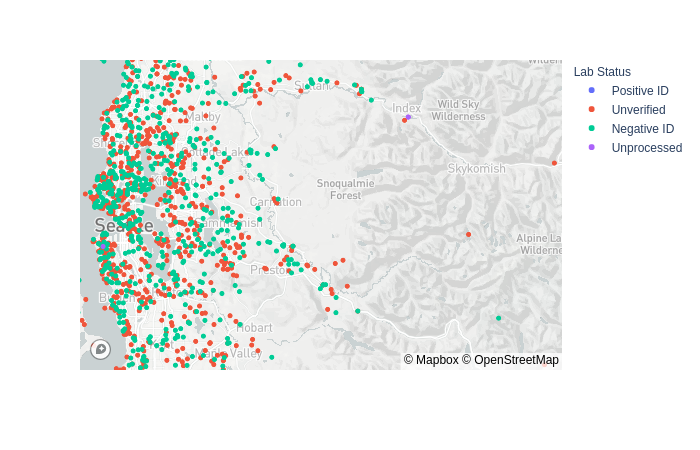

In [ ]:
fig.show(renderer="png")

In [ ]:
fig = px.bar(
    df.groupby(pd.Grouper(key="Detection Date",freq='M')).size(),
    log_y=True,
    )
fig.update_layout(
    title="All sighting events",
    yaxis_title="Events (log scale)",
    )
fig.show()

In [ ]:
subset = df["Detection Date"] >= datetime.datetime(2019, 1, 1)

fig = px.bar(
  df[subset].groupby([pd.Grouper(key="Detection Date",freq='M'), "Lab Status"]).size().reset_index(name='count'),
  x="Detection Date",
  y="count",
  color='Lab Status',
)

fig.show()

# Comments on sightings

* Unfortunately, about half of sightings are pending verification
* Of sightings that are verified, almost all are negative IDs
* In other words, positive IDs are very rare

# Confirmed positive IDs

In [ ]:
def make_fig(df):
  subset = df["Detection Date"] >= datetime.datetime(2015, 1, 1)
  df = df[subset]

  data_monthly = df\
    .groupby([pd.Grouper(key="Detection Date",freq='M'), "Lab Status"])\
    .size()\
    .reset_index(name="count")\
    .pivot(index="Detection Date", columns="Lab Status", values="count")\
    .fillna(0)
  fig = px.bar(
    data_monthly,
    x=data_monthly.index,
    y="Positive ID",
  )
  fig.update_layout(
    title="Confirmed positive IDs of Vespa Mandarinia since 2015"
  )
  return fig

fig = make_fig(df)
fig.show()

# Animation of sightings by year:

In [ ]:
def f(geo_df):
  geo_df = geo_df.sort_values(by="Detection Date")
  geo_df["yyyymm"] = geo_df["Detection Date"].dt.year * 100 + geo_df["Detection Date"].dt.month

  return px.scatter_mapbox(geo_df,
    lat=geo_df.geometry.y,
    lon=geo_df.geometry.x,
    hover_name="GlobalID",
    animation_frame="yyyymm",
    title="Animation of sightings by month, 2007 to present"
    )

fig = f(df)
fig.show()

# A proposed model of sightings

A model I would propose for this system is related to the "logistic growth with sustainable minimum" model:

$N' = r N (M - N) (N - K) $

where
* $N$ is the number of sightings
* $r$ is a constant growth rate
* $K$ is a maximum capacity
* $M$ is a minimum value for a sustainable population

In my model I vary the $M$ term

$M \to M [\frac{1}{2}(\cos\frac{2\pi(\text{month of year})}{12} + 1)]$

As a result, $M(\text{month of year})$ is high during the winter and approaches 0 in the summer.
  * This "sustainable minimum" size varies by time of year, oscillating between seasonal extremes
  * During the winter, there is a higher threshold, approaching $M$ for the population to survive
  * Conversely, during the summer the minimum sustainable population size vanishes to $0$.

This model is motivated by the following observations:
* There seems to be exponential growth followed by decay, each year
  * During winter, the population dies out (or, is no longer observed).
* Early years have sightings, but it seems to decay back to zero quickly
  * This suggests a minimum sustainable population size, and not just logistic growth.

## Simulations

Simulations of $N'$ given observed values for $N$ and some hand-picked values for $r$, $M$, and $K$ are:

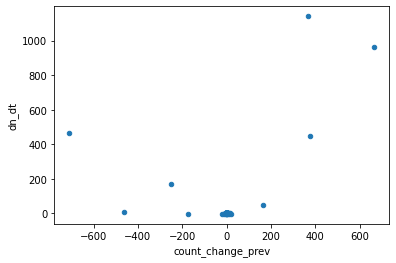

In [ ]:
monthly_counts = df.groupby(pd.Grouper(key="Detection Date",freq='M')).size().to_frame(name="count")
monthly_counts["count_change_prev"] = monthly_counts + monthly_counts - monthly_counts.rolling(2).sum().fillna(0)

import numpy as np

monthly_counts["r"] = 0.000001
monthly_counts["k"] = 2000.0
monthly_counts["m_scalar"] = (np.cos(monthly_counts.index.month * 2 * np.pi / 12) + 1) / 2
monthly_counts["m"] = 200.0 * monthly_counts["m_scalar"]

# monthly_counts["dn_dt"] = monthly_counts.apply(axis=1, func=lambda row: dn_dt(row["count"], 0.00000001, row.name.month, 2000.0))
monthly_counts["dn_dt"] = monthly_counts["r"] * monthly_counts["count"] * (monthly_counts["m"] - monthly_counts["count"]) * (monthly_counts["count"] - monthly_counts["k"])

monthly_counts.plot.scatter(x="count_change_prev", y="dn_dt")